#### A Quick Note ####

We found that using different subsets of our data affected our accuracy in significant ways. Thus, we have a section for each subset, accordingly labelled.

# 1. Exploratory Data Analysis #

Normalizing our data: Using Min-Max Normalization for our independent variables and one-hot encoding for our dependent variable.

In [3]:
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv("GenreDataModified.csv")
df = pd.DataFrame(data)
df.dropna(subset=['top genre','Id'], inplace=True)
df = df.dropna()

X = df.drop(['Id','title','artist','year','top genre', 'adjusted top genre'], axis = 1)
y = df['adjusted top genre']

#Normalize each fields of input
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X_rescaled = pd.DataFrame(data = X_rescaled, columns = X.columns)
#X_rescaled = X_rescaled.fillna(0)
print("Min Max Normalized X: \n")
print(X_rescaled)
print("\n")

#one-hot encoding
set_of_classes = y.value_counts().index.tolist()
set_of_classes= pd.DataFrame({'adjusted top genre': set_of_classes})
y_onehot = pd.get_dummies(y)
print("One Hot Encoded Y: \n")
print(y_onehot)

# Combine the normalized input features and the target variable
data0 = pd.concat([X, y], axis=1)			#data without onehot-encoding class
data1 = pd.concat([X_rescaled, y_onehot], axis=1)	#data with onehot-encoding class


Min Max Normalized X: 

          bpm      nrgy      dnce        dB      live       val       dur  \
0    0.328467  0.258065  0.346154  0.695652  0.120879  0.236559  0.125908   
1    0.313869  0.311828  0.576923  0.652174  0.120879  0.655914  0.355932   
2    0.788321  0.225806  0.371795  0.347826  0.120879  0.290323  0.324455   
3    0.430657  0.430108  0.487179  0.695652  0.142857  0.365591  0.230024   
4    0.350365  0.526882  0.679487  0.739130  0.109890  0.182796  0.302663   
..        ...       ...       ...       ...       ...       ...       ...   
433  0.131387  0.161290  0.000000  0.304348  0.087912  0.107527  0.280872   
434  0.627737  0.795699  0.448718  0.478261  0.230769  0.967742  0.118644   
435  0.773723  0.516129  0.705128  0.695652  0.197802  0.591398  0.462470   
436  0.751825  0.860215  0.589744  0.826087  0.043956  0.881720  0.225182   
437  0.313869  0.709677  0.641026  0.695652  0.131868  0.946237  0.443099   

        acous      spch       pop  
0    0.757576  

### i) Pairplot ### 

Generating a pairplot

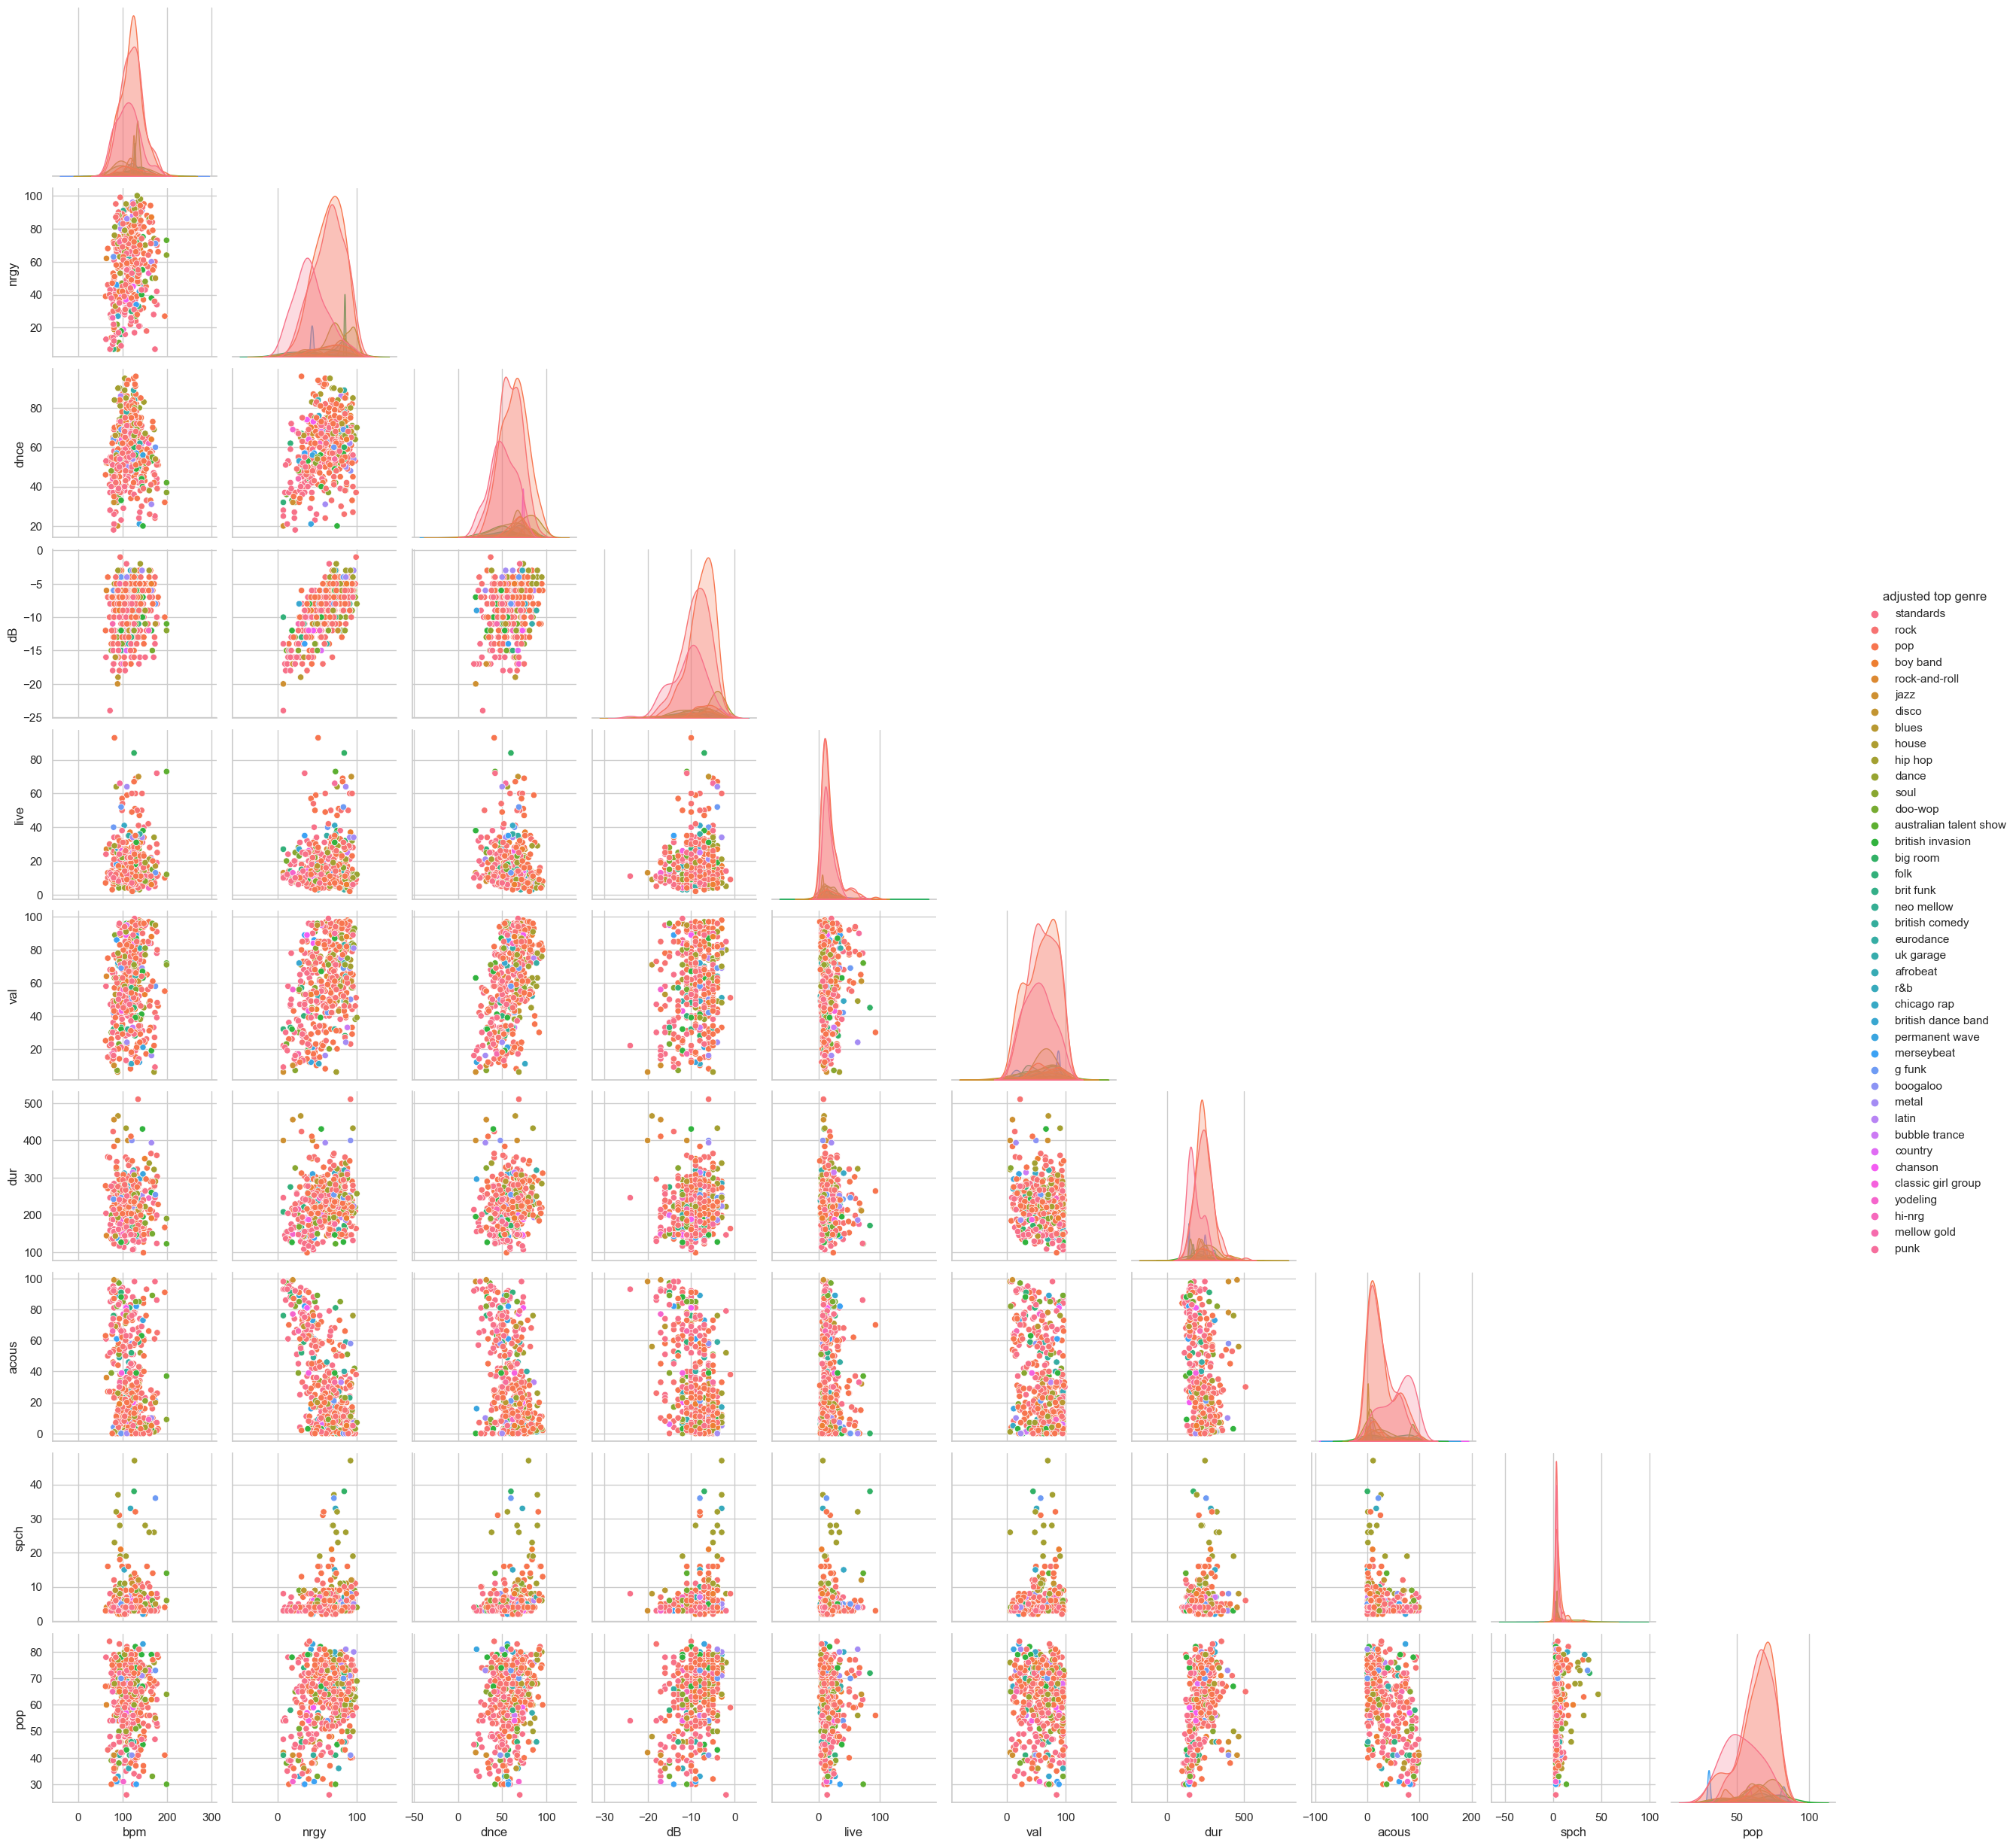

In [5]:
# Create a pair plot
import warnings

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
g = sns.pairplot(data=data0, hue='adjusted top genre', corner=True, palette='husl')

plt.show()

### ii) Boxplots ### 

Creating boxplots of our independent variables to scan for outliers

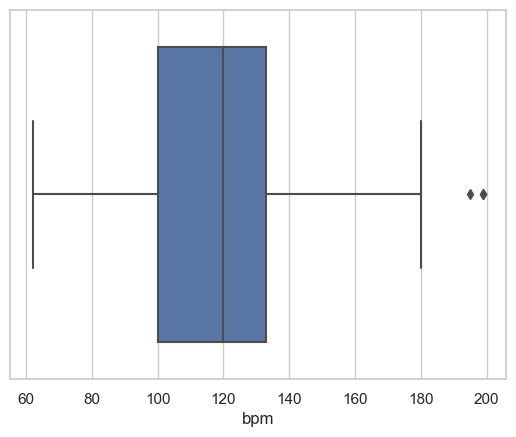

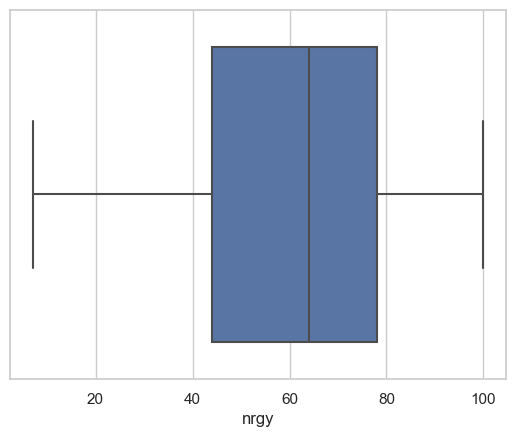

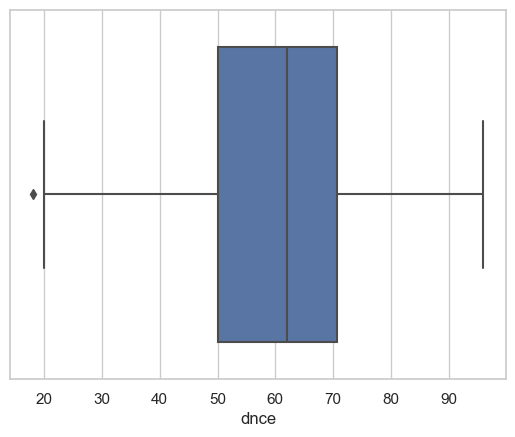

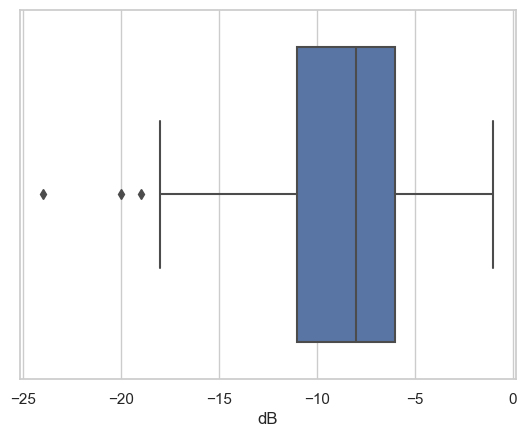

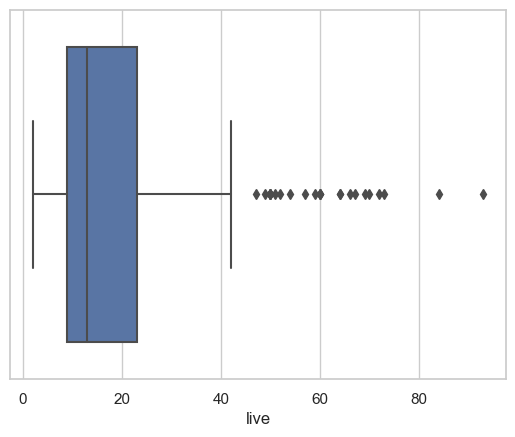

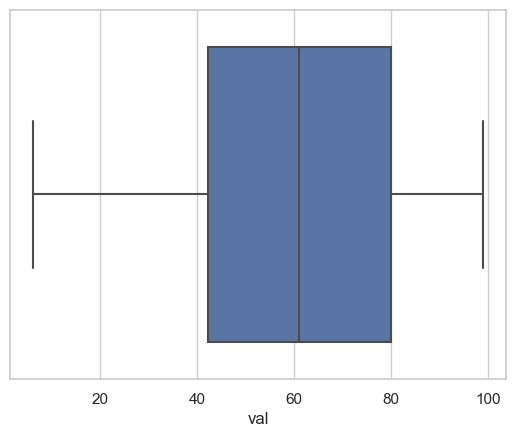

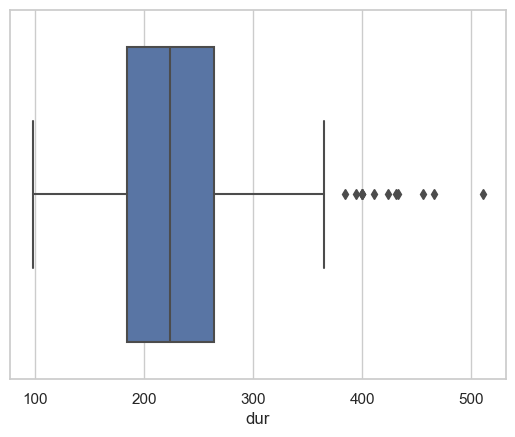

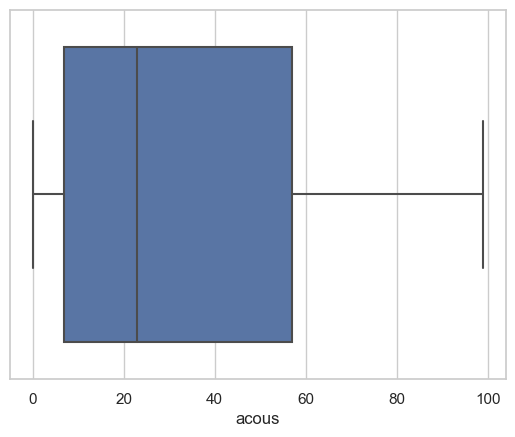

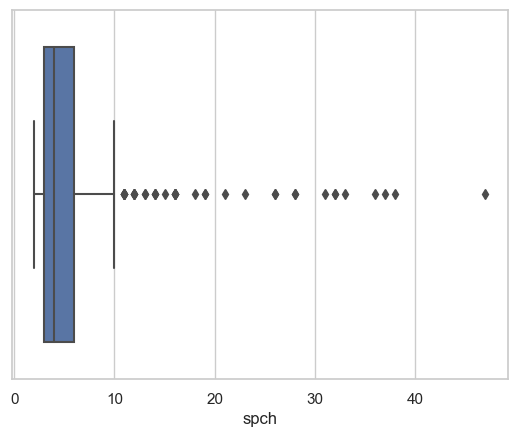

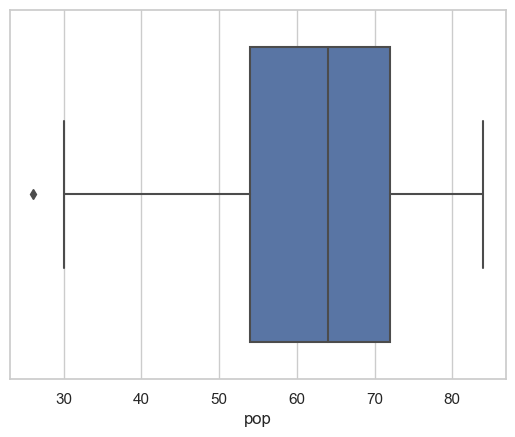

In [6]:
#Investigating possible outliers for various attributes
import seaborn as sns
sns.boxplot(x=df['bpm']) #outliers to right (not a lot)
plt.show()
sns.boxplot(x=df['nrgy']) #no outliers
plt.show()
sns.boxplot(x=df['dnce']) #outlier to left
plt.show()
sns.boxplot(x=df['dB']) # outliers to left (less)
plt.show()
sns.boxplot(x=df['live']) # many outliers (right)
plt.show()
sns.boxplot(x=df['val']) # no outliers
plt.show()
sns.boxplot(x=df['dur']) # many outliers (right)
plt.show()
sns.boxplot(x=df['acous']) # no visible outliers
plt.show()
sns.boxplot(x=df['spch']) # many outliers (right)
plt.show()
sns.boxplot(x=df['pop']) # less outliers (left)
plt.show()

### iii) Histograms ###

Investigating the skew of data using histograms of each indpendent variable

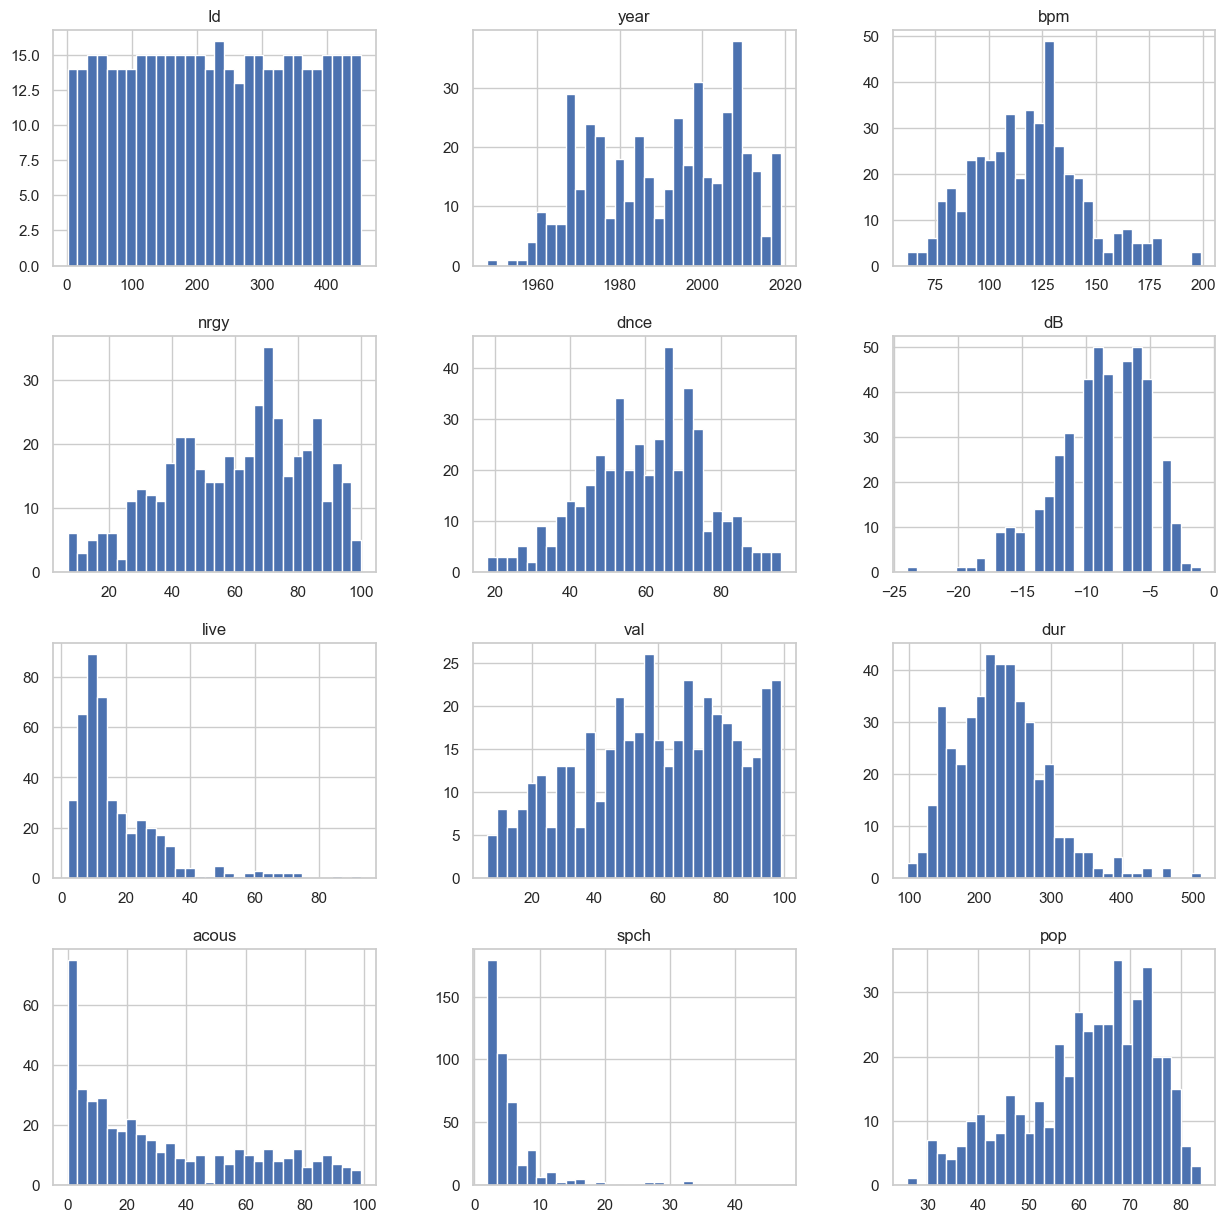

In [7]:
#Investigating skew of data
df.hist(bins=30, figsize=(15,15))
plt.show()

#right skewed for 'live', 'acous', 'spch', 'dur' attributes
#left skewed for 'nrgy', 'dB', 'val', 'pop' attributes
#roughly symmetrical for 'dnce', 'bpm' attributes
#ID and year distributions aren't being analyzed here -- categorical variables that don't affect response variable clas

## Conclusions ##

Distributions of attributes dnce, bpm, nrgy, and val are roughly (ROUGHLY) symmetrical so should contribute to more accurate response variable classifications whereas the skewed nature (indicating many outliers) of other attributes could contribute to more inaccurate predictions (higher variance).

# 2. Testing the Accuracy of Various Models with Year Excluded #

The attribute year will be excluded in this section

### i) Decision Tree, One-V.-Rest SVM (linear), One-V.-Rest SVM (poly), MLP, Optimal MLP, Random Forest, Gaussian Naive Bayes ###

In [8]:
import warnings
from sklearn.metrics import accuracy_score,f1_score, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


models = [
	("dtree", DecisionTreeClassifier()),
	("svm", OneVsRestClassifier(SVC(kernel='linear', C=1))),
	("svm_poly", OneVsRestClassifier(SVC(kernel='poly', C=1))),
	("mlp",  MLPClassifier()),
	("opt_mlp",  MLPClassifier()),
	("rand_forest", RandomForestClassifier()),
    ("gaussian_nb", GaussianNB()),
]

In [9]:
from sklearn.model_selection import learning_curve

def modelbuilding(Xval,yval):
	warnings.filterwarnings("ignore")

	df_metrics = pd.DataFrame(columns=["name", "accuracy", "precision", "f1_score"])

	x_train, x_test, y_train, y_test = train_test_split(Xval, yval, test_size=0.2, random_state=42)

	for name, model in models:
		model.fit(x_train, y_train)
		train_pred = model.predict(x_train)
		y_pred = model.predict(x_test)

		metrics = [name]
		metrics.append(accuracy_score(y_test, y_pred))
		metrics.append(precision_score(y_test, y_pred, average="weighted"))
		metrics.append(f1_score(y_test, y_pred, average="weighted"))

		df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics], columns=df_metrics.columns)], ignore_index=True)

		train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy')
		plt.figure()
		plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
		plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Accuracy')
		plt.xlabel('Training Examples')
		plt.ylabel('Accuracy')
		plt.title(f'Learning Curve for {name}')
		plt.legend()
		plt.show()

	display(df_metrics)

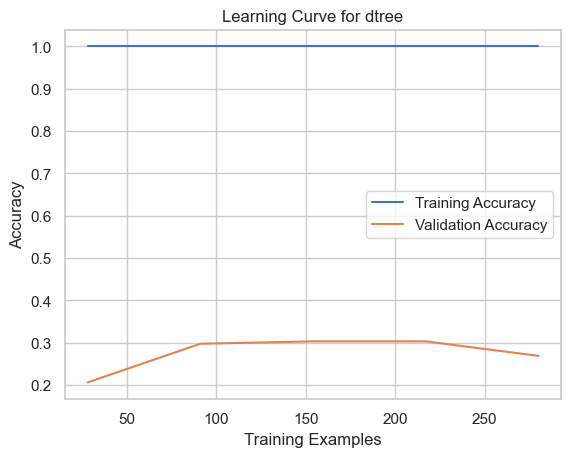

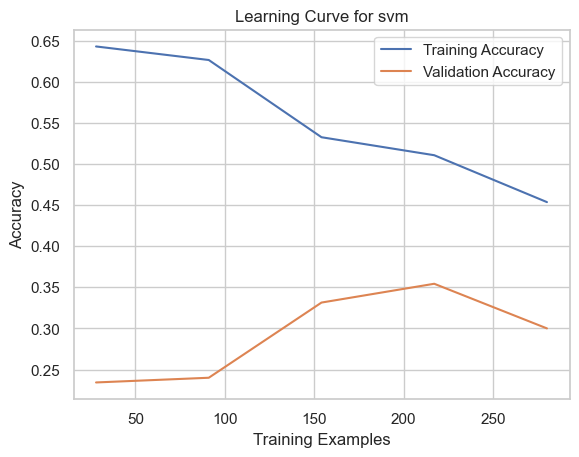

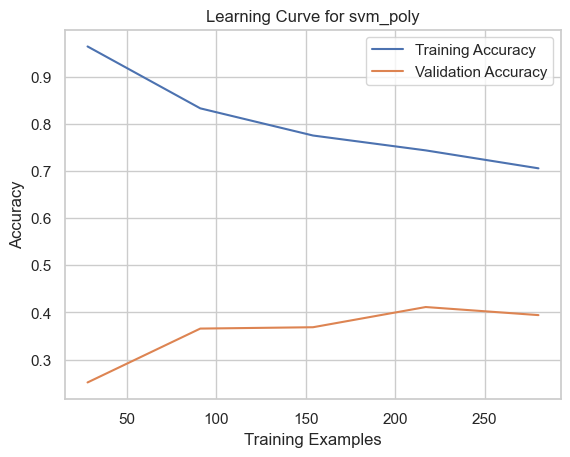

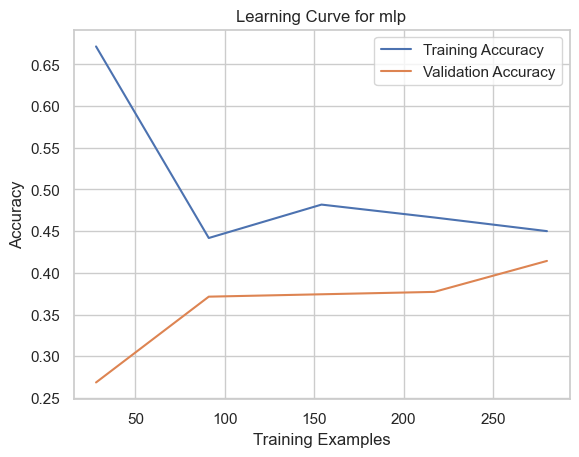

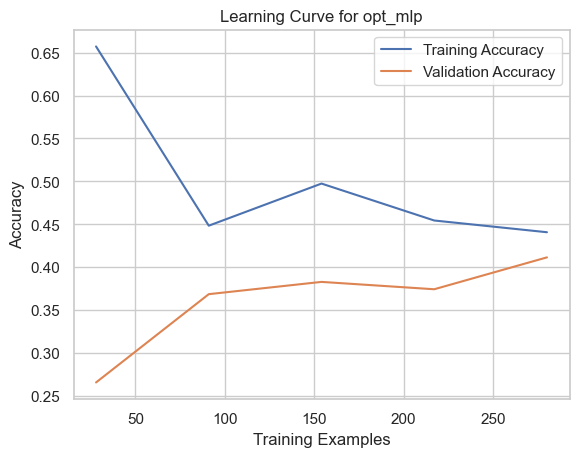

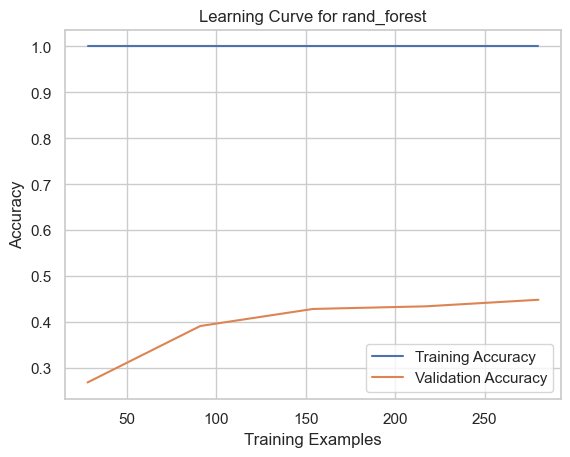

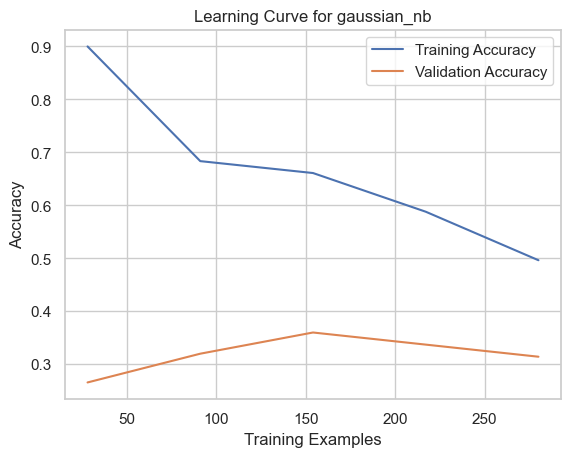

,name,accuracy,precision,f1_score
0,dtree,0.363636,0.340368,0.347808
1,svm,0.284091,0.290110,0.260455
2,svm_poly,0.375000,0.349867,0.359479
3,mlp,0.477273,0.377067,0.420395
4,opt_mlp,0.431818,0.339409,0.380029
5,rand_forest,0.409091,0.322571,0.360141
6,gaussian_nb,0.352273,0.416180,0.366710


In [10]:
modelbuilding(X_rescaled, y)

### ii) Artificial Neural Network ### 

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def ANNbuilding(Xval, yval, mlp):
	data_train, data_test, genre_train, genre_test = train_test_split(Xval, yval, test_size=0.2, random_state = 42)
	#so a neural net with 5 hidden layers, 160 nodes in first, 150 in next, 90 in third, 40 in fourth, 10 in fifth
	#i kinda experimented around with different parameters but this was yielding the best results so far
	#alpha is a regularization parameter to punish overfitting

	mlp.fit(data_train, genre_train)
	pred = mlp.predict(data_test)

	print("Accuracy: \n ", accuracy_score(genre_test, pred), '\n')

	print("Classification Report: ")
	print(classification_report(genre_test, pred))
	return mlp

In [12]:
mlp = MLPClassifier(solver = 'sgd', 
						alpha=0.0001, 
						random_state = 42, 
						activation = 'relu', 
						learning_rate_init = 0.15, 
						batch_size = 100, 
						hidden_layer_sizes = (160, 150, 90, 40,10), 
						max_iter = 500,
						#verbose = True
					)
ANNbuilding(X_rescaled,y,mlp)

Accuracy: 
  0.48863636363636365 

Classification Report: 
                  precision    recall  f1-score   support

           blues       0.00      0.00      0.00         1
        boy band       0.00      0.00      0.00         3
british invasion       0.00      0.00      0.00         1
     chicago rap       0.00      0.00      0.00         1
         country       0.00      0.00      0.00         1
           disco       0.00      0.00      0.00         1
       eurodance       0.00      0.00      0.00         1
          g funk       0.00      0.00      0.00         2
         hip hop       0.50      0.67      0.57         3
           house       0.00      0.00      0.00         1
            jazz       0.00      0.00      0.00         3
             pop       0.41      0.39      0.40        23
            rock       0.52      0.88      0.66        26
            soul       0.00      0.00      0.00         3
       standards       0.50      0.53      0.51        17
        yode

MLPClassifier(batch_size=100, hidden_layer_sizes=(160, 150, 90, 40, 10),
              learning_rate_init=0.15, max_iter=500, random_state=42,
              solver='sgd')

## Conclusions ##

It appears that, with year excluded, the highest accuracy that we were able to achieve (with an ANN) was 0.49, which is 49%

# 3. Data with Independent X-variable 'year' included #

The attribute year will be included in this section

We have to reset our X_rescaled variable because of our inclusion of the variable/attribute 'year':

In [13]:
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv("GenreDataModified.csv")
df = pd.DataFrame(data)
df = df.dropna()

X = df.drop(['Id','title','artist','top genre','adjusted top genre'], axis = 1)
y = df['adjusted top genre']


#Normalize each fields of input
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X_rescaled = pd.DataFrame(data = X_rescaled, columns = X.columns)
#X_rescaled = X_rescaled.fillna(0)
#print(X_rescaled)

#one-hot encoding
set_of_classes = y.value_counts().index.tolist()
set_of_classes= pd.DataFrame({'adjusted top genre': set_of_classes})
y_onehot = pd.get_dummies(y)
#print(y_onehot)

# Combine the normalized input features and the target variable
data0 = pd.concat([X, y], axis=1)			#data without onehot-encoding class
data1 = pd.concat([X_rescaled, y_onehot], axis=1)	#data with onehot-encoding class
#print(df.isnull().sum())


### i) Heatmap ###

Generating a heatmap for the independent variables ('year' included)

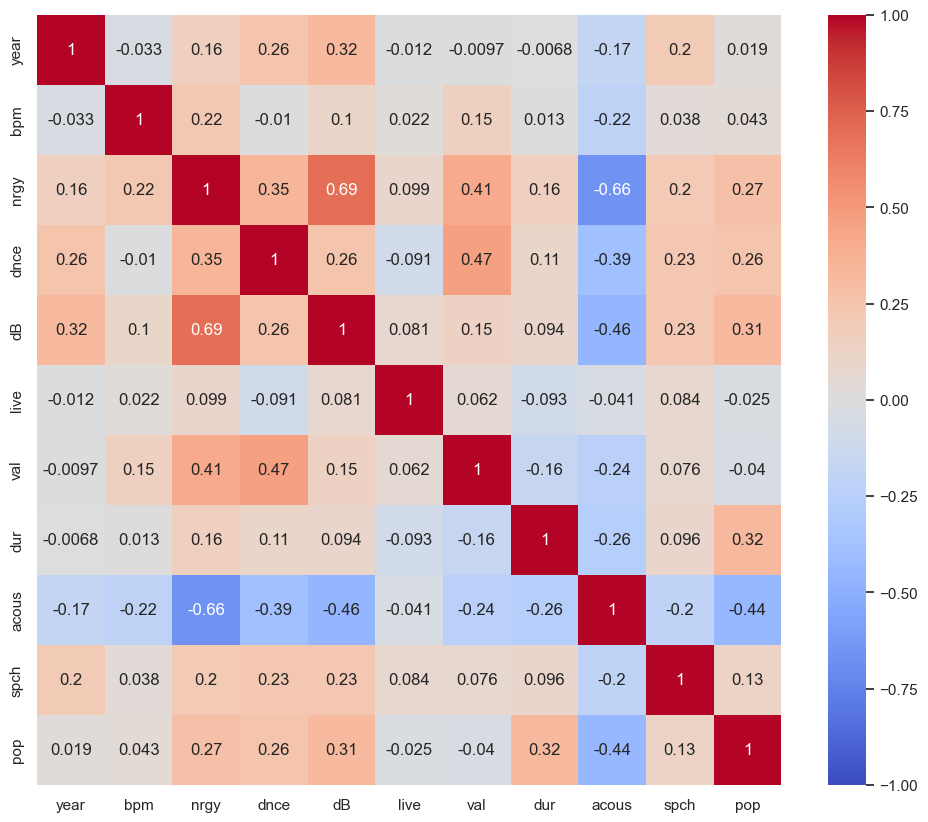

In [14]:
plt.figure(figsize=(12, 10))
autoCorrMat = X_rescaled.copy().corr()
heatResult = sns.heatmap(autoCorrMat, vmin=-1, vmax=1, center=0, annot=True, cmap= 'coolwarm')

### ii) Histograms to determine distribution of independent variables (year included) ### 

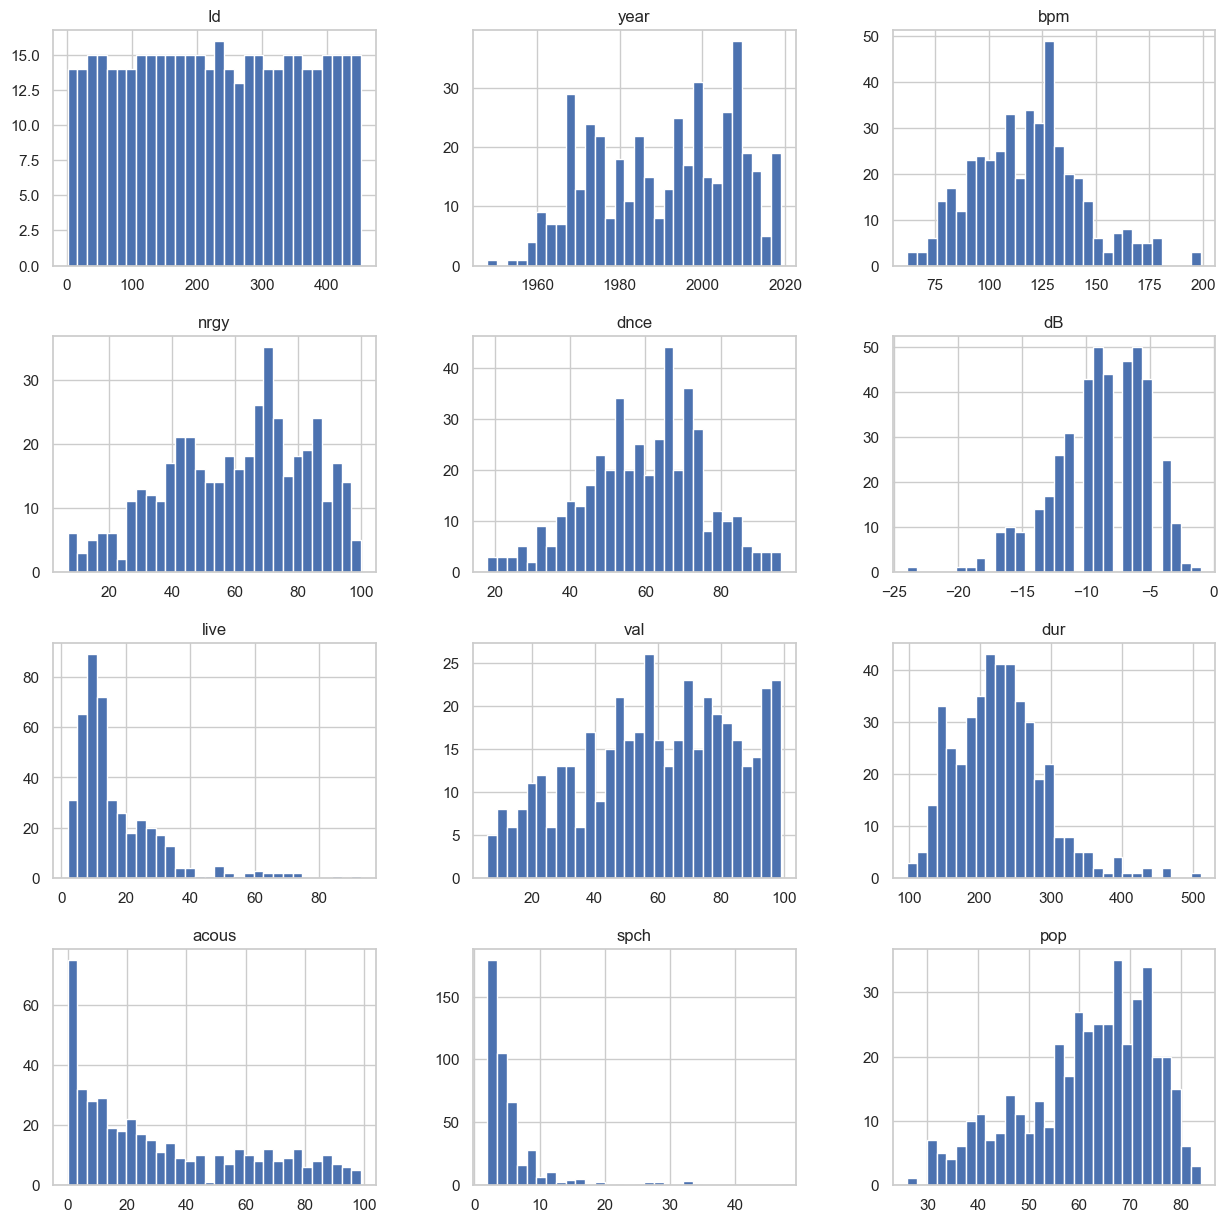

In [15]:
#Investigating skew of data
df.hist(bins=30, figsize=(15,15))
plt.show()

#right skewed for 'live', 'acous', 'spch', 'dur' attributes
#left skewed for 'nrgy', 'dB', 'val', 'pop' attributes
#roughly symmetrical for 'dnce', 'bpm' attributes
#year doesn't really have a discernable pattern, but can be ROUGHLY assumed to be symmetrical

## a) Testing Accuracy of Various Models with Year Left In ##

### i) Decision Tree, One-V.-Rest SVM (linear), One-V.-Rest SVM (poly), MLP, Optimal MLP, Random Forest, Gaussian Naive Bayes ###

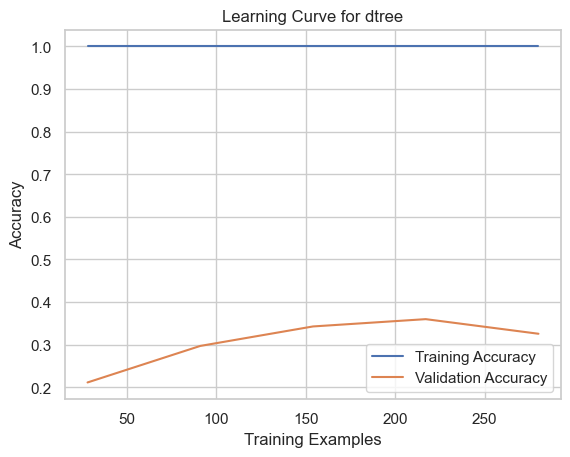

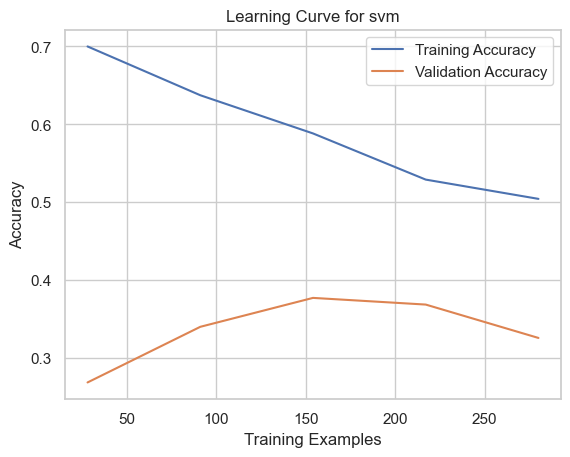

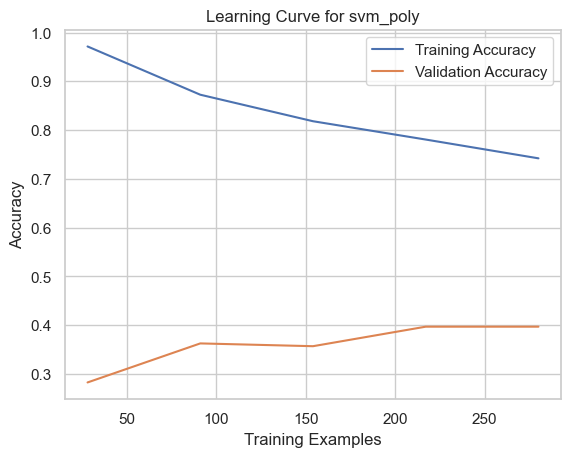

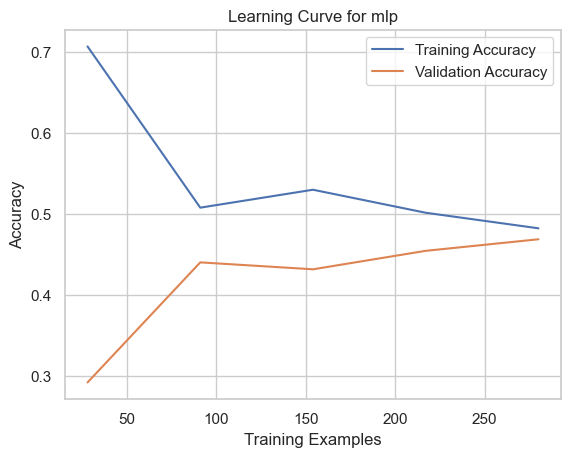

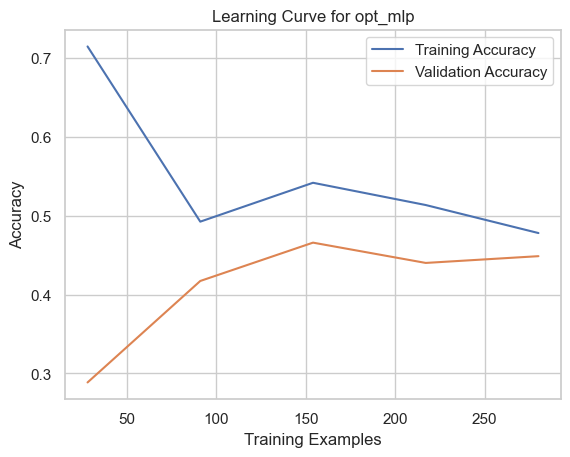

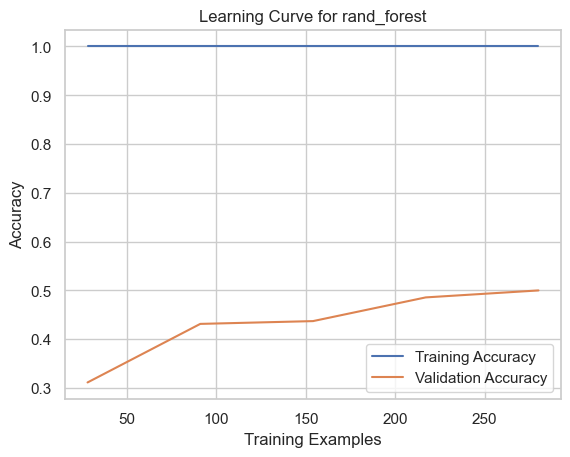

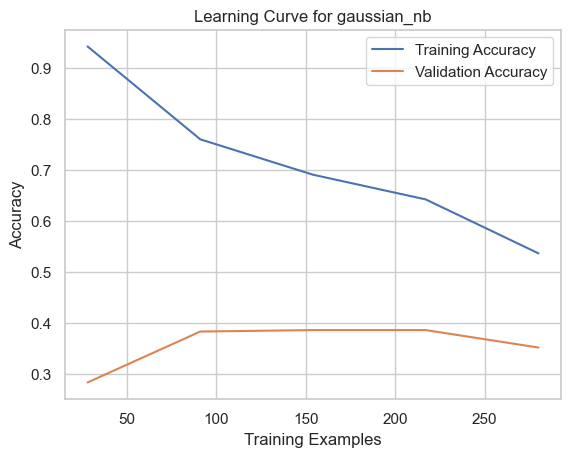

,name,accuracy,precision,f1_score
0,dtree,0.386364,0.409112,0.388111
1,svm,0.340909,0.398921,0.334504
2,svm_poly,0.420455,0.390662,0.401848
3,mlp,0.500000,0.392497,0.439575
4,opt_mlp,0.500000,0.393906,0.440153
5,rand_forest,0.488636,0.393170,0.433274
6,gaussian_nb,0.386364,0.453283,0.403514


In [16]:
modelbuilding(X_rescaled, y)

### ii) Artificial Neural Net ###

In [17]:
import pickle

mlp = MLPClassifier(solver = 'sgd', 
                    alpha=0.0000001, 
                    random_state = 42, 
                    activation = 'relu', 
                    learning_rate_init = 0.14, 
                    batch_size = 100, 
                    hidden_layer_sizes = (200, 190, 160, 140, 100), 
                    max_iter = 500,
                   #verbose = True
                   )
modelToSave = ANNbuilding(X_rescaled,y,mlp)

# Save the trained model using pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(modelToSave, file)

Accuracy: 
  0.5340909090909091 

Classification Report: 
                  precision    recall  f1-score   support

           blues       0.00      0.00      0.00         1
        boy band       0.00      0.00      0.00         3
british invasion       0.00      0.00      0.00         1
     chicago rap       0.00      0.00      0.00         1
         country       0.00      0.00      0.00         1
           disco       0.00      0.00      0.00         1
       eurodance       0.00      0.00      0.00         1
          g funk       0.00      0.00      0.00         2
         hip hop       0.00      0.00      0.00         3
           house       0.00      0.00      0.00         1
            jazz       0.00      0.00      0.00         3
             pop       0.47      0.74      0.58        23
            rock       0.61      0.77      0.68        26
            soul       0.00      0.00      0.00         3
       standards       0.53      0.59      0.56        17
        yodel

## b) Hyperparameter Tuning of Model with Highest Accuracy (ANN) (with year included) ##

In [18]:
from sklearn.model_selection import GridSearchCV

#X
X_rescaled

#y
y

#different hyperparameter variations
max_iterations = [500,800,1000]
hidden_layer_size = [(200, 190, 160, 140, 100), 
                     (300,250,200,150,100), 
                     (200,160,150,130,100,70), 
                     (150,130,120,110,100,70)]
learning_rates = 0.14 * np.arange(1, 3)
alpha = [(0.0000001), (0.000001), (0.00000001)]
batch_sizes = [100]

param_grid = dict(learning_rate_init = learning_rates, 
                  hidden_layer_sizes = hidden_layer_size, 
                  max_iter = max_iterations,
                  batch_size = batch_sizes,
                 alpha = alpha)

# setting model
mlp = MLPClassifier(
                    solver = 'sgd', 
                    alpha=0.0000001, 
                    random_state = 42, 
                    activation = 'relu', 
                    learning_rate_init = 0.14, 
                    batch_size = 100, 
                    hidden_layer_sizes = (200, 190, 160, 140, 100), 
                    max_iter = 500,
                   #verbose = True
                   )

# Grid Search
grid = GridSearchCV(estimator = mlp, param_grid = param_grid, scoring = 'accuracy', n_jobs=-1)

grid.fit(X_rescaled,y)

GridSearchCV(estimator=MLPClassifier(alpha=1e-07, batch_size=100,
                                     hidden_layer_sizes=(200, 190, 160, 140,
                                                         100),
                                     learning_rate_init=0.14, max_iter=500,
                                     random_state=42, solver='sgd'),
             n_jobs=-1,
             param_grid={'alpha': [1e-07, 1e-06, 1e-08], 'batch_size': [100],
                         'hidden_layer_sizes': [(200, 190, 160, 140, 100),
                                                (300, 250, 200, 150, 100),
                                                (200, 160, 150, 130, 100, 70),
                                                (150, 130, 120, 110, 100, 70)],
                         'learning_rate_init': array([0.14, 0.28]),
                         'max_iter': [500, 800, 1000]},
             scoring='accuracy')

In [19]:
cv_results = grid.cv_results_

#for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    #print(f"Accuracy: {mean_score:.4f} with parameters: {params}")
    
print("Optimal Hyper-parameters: \n", grid.best_params_, '\n')
print("Optimal Accuracy: \n", grid.best_score_,'\n')

#it seems that the different variations that grid search tried did not include my own manually inputted hyperparameters. This could be because grid search is comparing 
#a broader range of hyperparameters and evaluated different combinations that didn't happen to include my own manually coded hyperparameter values 
#that resulted in a higher accuracy. The optimal set of hyperparameters produced by grid search (obtained through the various combinations that it tried) produced
#a lower accuracy than my own manual encoding of hyperparameter values

Optimal Hyper-parameters: 
 {'alpha': 1e-08, 'batch_size': 100, 'hidden_layer_sizes': (300, 250, 200, 150, 100), 'learning_rate_init': 0.14, 'max_iter': 500} 

Optimal Accuracy: 
 0.4476489028213166 



## Conclusions ##

It appears that, in general, including year as an attribute improves the accuracy of our models. The accuracy of each model is higher in comparison to its previous counterpart (with the exception being the mlp model maintaining an accuracy of 0.4659). Furthermore, the ANN produces the highest accuracy thusfar of 0.5341 (53%). We attempted to use hyperparameter tuning to further increase the accuracy by pairing the best hyperparameters, but the grid search produced an optimal accuracy of 0.4476 (45%), which is lower than the accuracy produced by our manually coded ANN. This could be because the grid search did not include our own manually inputted hyperparameters, caused by the grid search comparing a broader range of hyperparameters and evaluating different combinations (that didn't happen to include our manually coded hyperparameter values). The optimal set of hyperparameters produced by grid search (obtained through the various combinations that it tried) produced a lower accuracy than our own manual encoding of hyperparameter values.

In summary, the highest accuracy is 53%, produced by a manually coded ANN.

# 4. Removing Outliers (for data with year included) #

The attribute year will be included, and any outliers that have been identified will be exlcuded in this section

In [20]:
# Concatenate X_rescaled and y into a new DataFrame
dfOutliersRemove = pd.concat([X_rescaled, y], axis=1)

# Specify numerical columns
numerical_columns = ['live', 'dur', 'spch']

# Loop through numerical columns to handle outliers
for column in numerical_columns:
    dfOutliersRemove = dfOutliersRemove[np.abs(dfOutliersRemove[column] - dfOutliersRemove[column].mean()) <= (3 * dfOutliersRemove[column].std())]

dfOutliersRemove = dfOutliersRemove.dropna()
# Separate X_rescaled and y after handling outliers
X_rescaled = dfOutliersRemove.drop('adjusted top genre', axis=1)
y = dfOutliersRemove['adjusted top genre']

dfOutliersRemove.to_csv('NoOutliers.csv', index=False)

## a) Testing the Accuracy of Several Different Models with Outliers Removed (year included) ##

### i) Decision Tree, One-V.-Rest SVM (linear), One-V.-Rest SVM (poly), MLP, Optimal MLP, Random Forest, Gaussian Naive Bayes ###

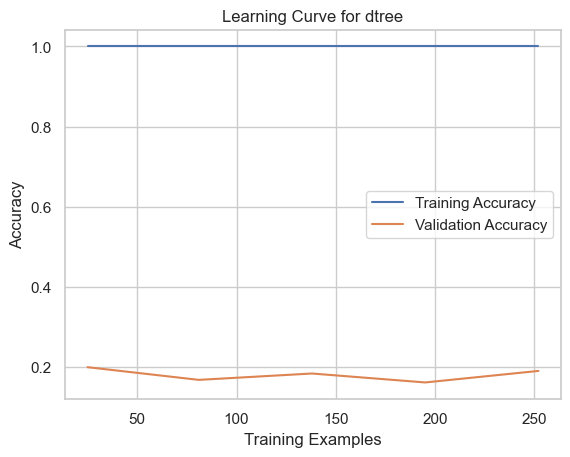

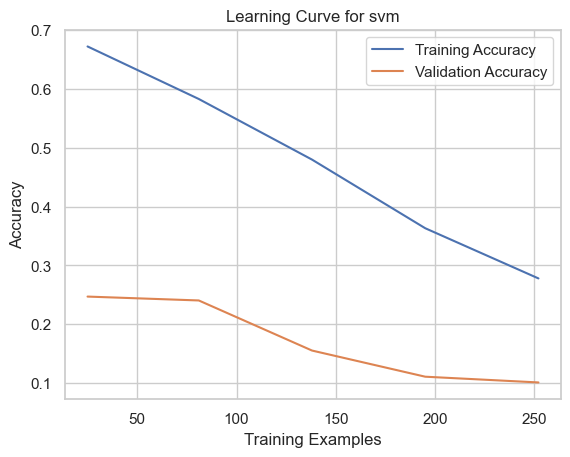

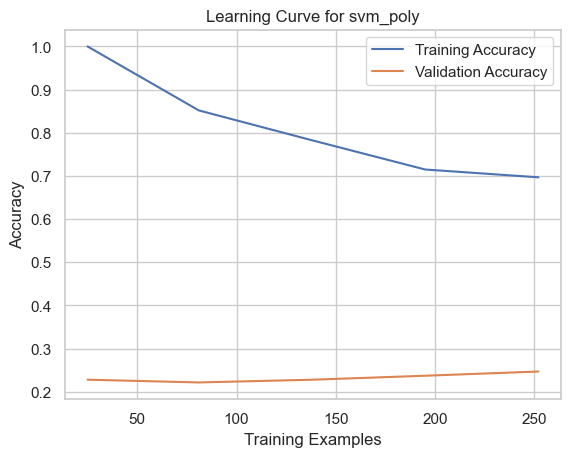

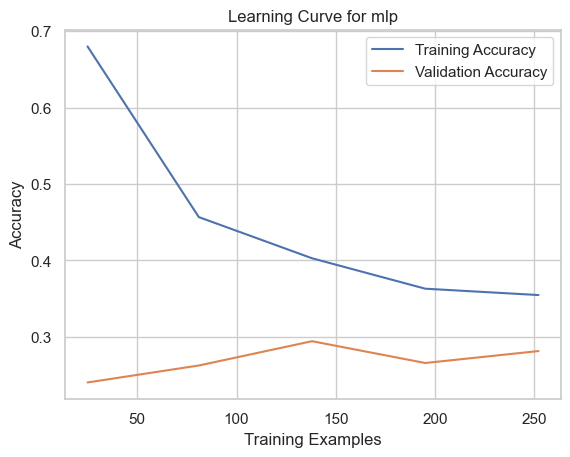

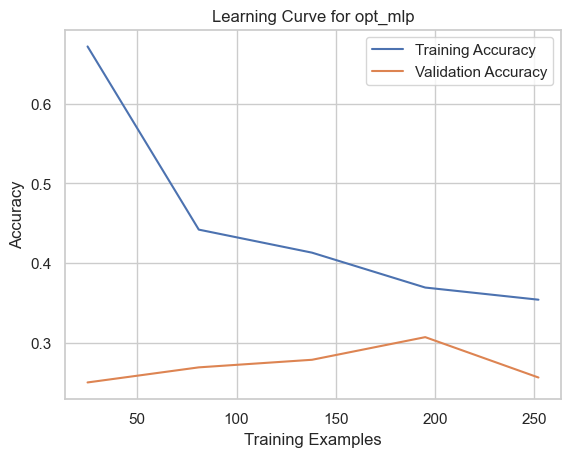

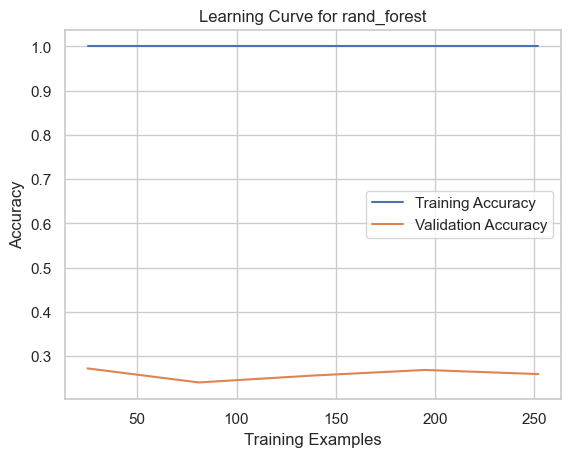

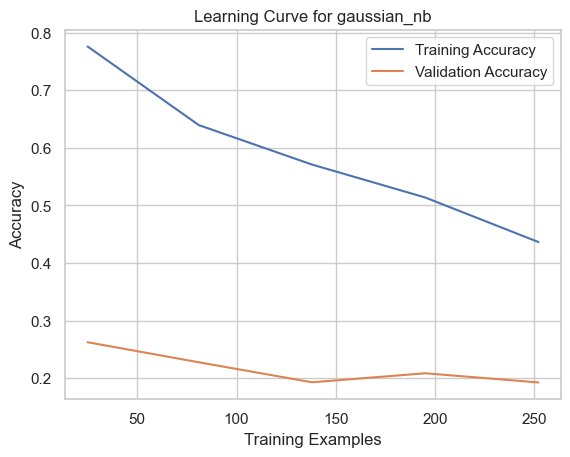

,name,accuracy,precision,f1_score
0,dtree,0.164557,0.153819,0.157718
1,svm,0.088608,0.189592,0.103728
2,svm_poly,0.113924,0.111031,0.111674
3,mlp,0.278481,0.159574,0.199185
4,opt_mlp,0.278481,0.156623,0.199399
5,rand_forest,0.253165,0.152643,0.189146
6,gaussian_nb,0.177215,0.199271,0.164245


In [21]:
modelbuilding(X_rescaled,y)

### ii) Artificial Neural Network ### 

In [22]:
mlp = MLPClassifier(solver = 'sgd', 
                    alpha=0.0000001, 
                    random_state = 42, 
                    activation = 'relu', 
                    learning_rate_init = 0.14, 
                    batch_size = 100, 
                    hidden_layer_sizes = (200, 190, 160, 140, 100), 
                    max_iter = 500,
                   #verbose = True
                   )
ANNbuilding(X_rescaled,y,mlp)

Accuracy: 
  0.21518987341772153 

Classification Report: 
                        precision    recall  f1-score   support

australian talent show       0.00      0.00      0.00         1
                 blues       0.00      0.00      0.00         3
              boogaloo       0.00      0.00      0.00         1
              boy band       0.00      0.00      0.00         2
    british dance band       0.00      0.00      0.00         1
      british invasion       0.00      0.00      0.00         2
                 dance       0.00      0.00      0.00         2
               doo-wop       0.00      0.00      0.00         3
             eurodance       0.00      0.00      0.00         1
               hip hop       0.00      0.00      0.00         1
                 metal       0.00      0.00      0.00         2
            neo mellow       0.00      0.00      0.00         1
       permanent wave        0.00      0.00      0.00         1
                   pop       0.26      0.46 

MLPClassifier(alpha=1e-07, batch_size=100,
              hidden_layer_sizes=(200, 190, 160, 140, 100),
              learning_rate_init=0.14, max_iter=500, random_state=42,
              solver='sgd')

## Conclusions ##

It appears that removing outliers from our dataset actually causes our models to perform much worse than keeping the outliers in. The accuracy of all of our models is almost halved when the outliers are removed.

## A Quick Note ##

To get our modified genres, we ran some code: There's no need to run this code as we have already added the column of modified data to our dataset to be used as our response variable. The code is simply there for reference (to show what we did)

In [23]:
"""
import csv
import pandas as pd

existing_csv_path = 'GenreDataModified.csv'

check_data = pd.read_csv(existing_csv_path)
check_df = pd.DataFrame(check_data)

if 'adjusted top genre' in check_df.columns:
	dataNEW = pd.read_csv('GenreDataModified.csv')
	dfNEW = pd.DataFrame(dataNEW)

	print(dfNEW)
else:
	data = pd.read_csv('GenreData.csv')
	#print (df)
	df = pd.DataFrame(data)
	df.dropna(subset=['top genre'], inplace=True)
	#print(df.nunique())
	#print(df)
	unique_genres = df['top genre'].unique()

	#for i in range(len(unique_genres)):
		#print(unique_genres[i] + ' ->')
		
		
	genres_mapping = '''adult standards -> standards
	glam rock -> rock
	pop -> pop
	album rock -> rock
	boy band -> boy band
	brill building pop -> pop
	rock-and-roll -> rock-and-roll
	country rock -> rock
	canadian pop -> pop
	dance pop -> pop
	europop -> pop
	bebop -> jazz
	art rock -> rock
	disco -> disco
	blues -> blues
	barbadian pop -> pop
	deep adult standards -> standards
	deep house -> house
	atl hip hop -> hip hop
	dance rock -> rock
	disco house -> house
	bubblegum dance -> dance
	classic soul -> soul
	classic uk pop -> pop
	east coast hip hop -> hip hop
	doo-wop -> doo-wop
	britpop -> pop
	british blues -> blues
	soft rock -> rock
	australian talent show -> australian talent show
	art pop -> pop
	british soul -> soul
	british invasion -> british invasion
	belgian pop -> pop
	big room -> big room
	german dance -> dance
	italian pop -> pop
	british folk -> folk
	brit funk -> brit funk
	chicago soul -> soul
	neo mellow -> neo mellow
	british comedy -> british comedy
	hip hop -> hip hop
	new wave pop -> pop
	eurodance -> eurodance
	detroit hip hop -> hip hop
	classic rock -> rock
	uk garage -> uk garage
	afrobeat -> afrobeat
	r&b -> r&b
	chicago rap -> chicago rap
	classic danish pop -> pop
	british dance band -> british dance band
	drone folk -> folk
	permanent wave -> permanent wave 
	merseybeat -> merseybeat
	g funk -> g funk
	blues rock -> rock
	celtic rock -> rock
	bow pop -> pop
	australian rock -> rock
	boogaloo -> boogaloo
	alternative metal -> metal
	belgian dance -> dance
	glam metal -> metal
	latin -> latin
	baroque pop -> pop
	bubble trance -> bubble trance
	canadian folk -> folk
	american folk revival -> folk
	country -> country
	chanson -> chanson
	bubblegum pop -> pop
	classic girl group -> classic girl group
	yodeling -> yodeling
	afropop -> pop
	hi-nrg -> hi-nrg
	louisiana blues -> blues
	hip pop -> pop
	mellow gold -> mellow gold
	avant-garde jazz -> jazz
	bronx hip hop -> hip hop
	glam punk -> punk
	german alternative rock -> rock
	acoustic blues -> blues
	alternative rock -> rock
	'''

	entries = [entry.split(' -> ') for entry in genres_mapping.strip().split('\n')]
	right_side_dict = {left: right for left, right in entries}

	with open(existing_csv_path, 'r', newline='') as csvfile:
		reader = csv.reader(csvfile)
		header = next(reader)  

		left_side_index = header.index('top genre') 

		header.append('adjusted top genre') 

		rows = list(reader)
	
		for row in rows:
			left_side_value = row[left_side_index]
			right_side_value = right_side_dict.get(left_side_value, 'Unknown')
			row.append(right_side_value)

	with open(existing_csv_path, 'w', newline='') as csvfile:
		writer = csv.writer(csvfile)
		writer.writerow(header)
		writer.writerows(rows)

	print("Done.")

	dataNEW = pd.read_csv("GenreData.csv")
	dfNEW = pd.DataFrame(dataNEW)
	df.dropna(subset=['top genre'], inplace=True)

	print(dfNEW)

"""

'\nimport csv\nimport pandas as pd\n\nexisting_csv_path = \'GenreDataModified.csv\'\n\ncheck_data = pd.read_csv(existing_csv_path)\ncheck_df = pd.DataFrame(check_data)\n\nif \'adjusted top genre\' in check_df.columns:\n\tdataNEW = pd.read_csv(\'GenreDataModified.csv\')\n\tdfNEW = pd.DataFrame(dataNEW)\n\n\tprint(dfNEW)\nelse:\n\tdata = pd.read_csv(\'GenreData.csv\')\n\t#print (df)\n\tdf = pd.DataFrame(data)\n\tdf.dropna(subset=[\'top genre\'], inplace=True)\n\t#print(df.nunique())\n\t#print(df)\n\tunique_genres = df[\'top genre\'].unique()\n\n\t#for i in range(len(unique_genres)):\n\t\t#print(unique_genres[i] + \' ->\')\n\t\t\n\t\t\n\tgenres_mapping = \'\'\'adult standards -> standards\n\tglam rock -> rock\n\tpop -> pop\n\talbum rock -> rock\n\tboy band -> boy band\n\tbrill building pop -> pop\n\trock-and-roll -> rock-and-roll\n\tcountry rock -> rock\n\tcanadian pop -> pop\n\tdance pop -> pop\n\teuropop -> pop\n\tbebop -> jazz\n\tart rock -> rock\n\tdisco -> disco\n\tblues -> blues\n\t